# Introduction

The goal is to solve **binary classification** problem with **unbalanced data**. Given dataset containing current and past loans granted by the company, we want to **predict the loan status (1 or 0)** where frequency of 0s is greater than frequency of 1s.

# Prerequisites and requirements

* Python 3.7
* Jupyter
* scikit-learn
* Matplotlib
* Seaborn
* NumPy
* Pandas

In [1]:
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Preparing data

At first I will load the data and sample **80 000 rows** (because I lack computing power on my laptop).

In [3]:
df = pd.read_csv('loan.csv').sample(80000, random_state=42)

In [4]:
df.shape

(80000, 14)

There are **14 columns** in our dataframe. Let's now look at some examples from our dataset.

In [5]:
df.head()

,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,issue_d,loan_status,dti,earliest_cr_line,recoveries,last_pymnt_d,application_type
1758049,36 months,12.12,1164.51,B,B3,RENT,90000.0,Jun-2013,Fully Paid,3.51,Nov-1997,0.0,Dec-2013,Individual
686533,60 months,10.75,648.54,B,B4,RENT,100000.0,Apr-2016,Current,22.85,Jun-2011,0.0,Feb-2019,Individual
900721,36 months,7.49,466.53,A,A4,OWN,100000.0,Oct-2016,Fully Paid,6.71,Apr-1996,0.0,Nov-2017,Individual
1727912,60 months,21.15,651.31,E,E2,RENT,58000.0,Sep-2013,Fully Paid,15.50,Aug-1998,0.0,Sep-2018,Individual
539691,36 months,8.59,455.18,A,A5,MORTGAGE,90000.0,Aug-2016,Current,19.88,Dec-2003,0.0,Feb-2019,Individual


At a glance, **both categorical and non-categorical data are available**. Let's now check for more details about the data.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 1758049 to 2145511
Data columns (total 14 columns):
term                80000 non-null object
int_rate            80000 non-null float64
installment         80000 non-null float64
grade               80000 non-null object
sub_grade           80000 non-null object
home_ownership      80000 non-null object
annual_inc          80000 non-null float64
issue_d             80000 non-null object
loan_status         80000 non-null object
dti                 79944 non-null float64
earliest_cr_line    79998 non-null object
recoveries          80000 non-null float64
last_pymnt_d        79906 non-null object
application_type    80000 non-null object
dtypes: float64(5), object(9)
memory usage: 9.2+ MB


As we see, **some data points have missing values**. We will need to deal with NaN values further, at the preprocessing step.

# Preprocessing

At first I will analyze and preprocess **labels**. Then, I will do the same with both **categorical** and **non-categorical features**.

## Labels

Our label is column ***loan_status***. As shown above, it's values are categorical, therefore I will display ratios of it's unique values.

In [7]:
def plot_ratio(df, name):
    display(df[name].value_counts(normalize=True).to_frame().reset_index().rename(columns={'index': name, name: 'ratio'}))
    sns.countplot(x=name, data=df)

,loan_status,ratio
0,Fully Paid,0.461087
1,Current,0.406913
2,Charged Off,0.115400
3,Late (31-120 days),0.009600
4,In Grace Period,0.004063
5,Late (16-30 days),0.001762
6,Does not meet the credit policy. Status:Fully ...,0.000775
7,Does not meet the credit policy. Status:Charge...,0.000387
8,Default,0.000013


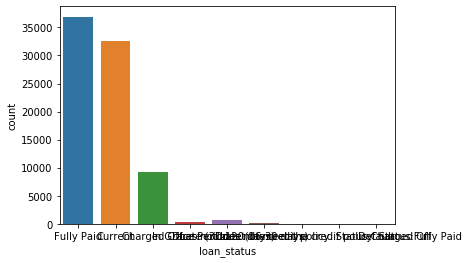

In [8]:
plot_ratio(df, 'loan_status')

Despite 9 unique values are available, we are going to **distinguish between only 2 unique values**:
* **1.0** - if ***loan_status*** is equal to ***Charged Off***, ***Default***, ***Does not meet the credit policy. Status:Charged Off*** or ***Late (31-120 days)***
* **0.0** - otherwise

In [9]:
df.loan_status = df.loan_status.apply(
    lambda x: 1.0 if x in ['Charged Off', 'Default', 'Late (31-120 days)',
                           'Does not meet the credit policy. Status:Charged Off'] else 0.0)

Let's now see **how unbalanced** are our labels.

,loan_status,ratio
0,0.0,0.8746
1,1.0,0.1254


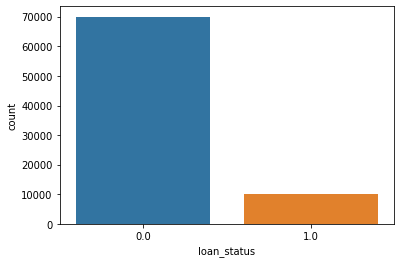

In [10]:
plot_ratio(df, 'loan_status')

Our labels are **quite unbalanced**. Only about **12.5% of them are positive**. We will need to deal with this further, while applying train-test split and training the classification model.

We have seen and preprocessed our labels. Let's now look at available **features**. I will start from analyzing **categorical features**.

## Categorical features

Let's see **how many unique values** different categorical features contain.

In [11]:
df.drop(columns=['loan_status']).select_dtypes(object).nunique().sort_values().to_frame().reset_index().rename(columns={'index': 'feature', 0: 'unique values'})

,feature,unique values
0,application_type,2
1,term,3
2,home_ownership,6
3,grade,7
4,sub_grade,35
5,last_pymnt_d,129
6,issue_d,138
7,earliest_cr_line,636


Let's start from analyzing features with the smallest number of unique values.

### application_type

Variable ***application_type*** has 2 unique values.

,application_type,ratio
0,Individual,0.946937
1,Joint App,0.053062


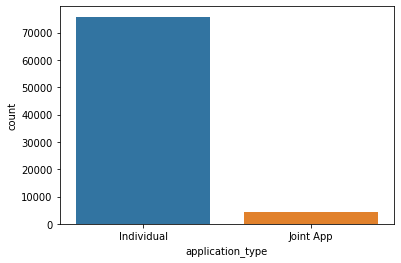

In [12]:
plot_ratio(df, 'application_type')

Since we are dealing with binary variable, we can simply use **LabelEncoder** and convert it into non-categorical variable.

In [13]:
df.application_type = LabelEncoder().fit_transform(df.application_type).astype('float64')

### term

Variable ***term*** has 3 unique values.

,term,ratio
0,36 months,0.714888
1,60 months,0.285100
2,36 months,0.000013


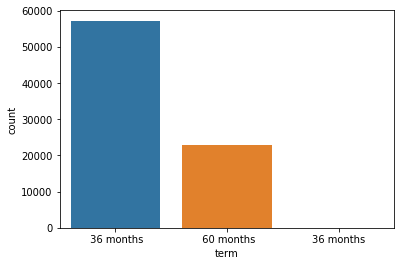

In [14]:
plot_ratio(df, 'term')

The variable **sometimes contains a whitespace in it's name**. Since this variable has numerical meaning, I will **extract this number (36 or 60) from every value in this column** by splitting stringified value and taking the first element. From now on this variable will be non-categorical.

In [15]:
df.term = df.term.apply(lambda  x: float(x.split()[0]))

### home_ownership

Variable ***home_ownership*** has 6 unique values.

,home_ownership,ratio
0,MORTGAGE,0.487000
1,RENT,0.401037
2,OWN,0.111600
3,ANY,0.000300
4,OTHER,0.000050
5,NONE,0.000013


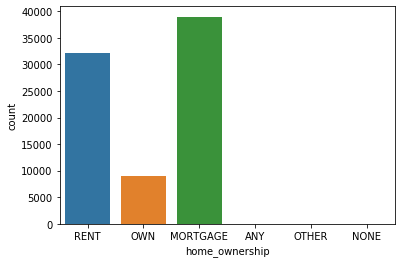

In [16]:
plot_ratio(df, 'home_ownership')

Since we are dealing with categorical variable with multiple values, we need to apply **one hot encoding**.

In [17]:
df = pd.get_dummies(df, columns=['home_ownership'], dtype='float64')

### grade

Variable ***grade*** has 7 unique values.

,grade,ratio
0,B,0.290888
1,C,0.287612
2,A,0.191887
3,D,0.144313
4,E,0.061687
5,F,0.018050
6,G,0.005562


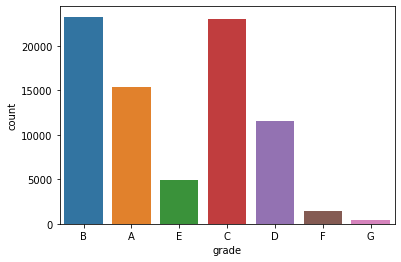

In [18]:
plot_ratio(df, 'grade')

I will use **one hot encoding** again.

In [19]:
df = pd.get_dummies(df, columns=['grade'], dtype='float64')

### sub_grade

Variable ***sub_grade*** has 35 unique values.

,sub_grade,ratio
0,C1,0.065650
1,B4,0.061325
2,B5,0.061250
3,C2,0.058075
4,B3,0.057287
...,...,...
30,G1,0.001937
31,G2,0.001075
32,G3,0.001000
33,G4,0.000812


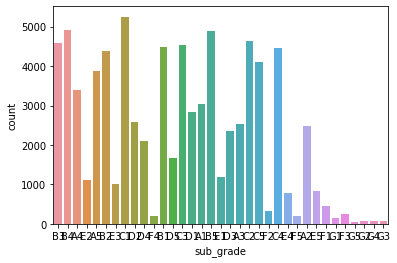

In [20]:
plot_ratio(df, 'sub_grade')

Again - **one hot encoding**.

In [21]:
df = pd.get_dummies(df, columns=['sub_grade'], dtype='float64')

### Dates: last_pymnt_d, issue_d and earliest_cr_line

Variables ***last_pymnt_d***, ***issue_d*** and ***earliest_cr_line*** are dates. As I guessed, these dates occured to be dependent on each other. All dates from ***earliest_cr_line*** are earlier than dates from ***issue_d***  and all dates from ***issue_d***  are earlier than dates from ***last_pymnt_d***. Therefore, I decided to convert these variables into floats representing **number of days since 1930**. It can be beneficial since I will be using distance-based algorithms for training. From now on all dates will be represented as floating point, non-categorical variables.

In [22]:
def _str_date_to_datetime(str_date):
    if type(str_date) != float:
        return datetime.strptime(str_date, '%b-%Y')
    return np.nan


def fix_dates(df):
    date_cols = ['earliest_cr_line', 'issue_d', 'last_pymnt_d']
    initial_date = datetime.strptime('Jan-1930', '%b-%Y')
    df[date_cols] = df[date_cols].applymap(_str_date_to_datetime)
    df.last_pymnt_d = (df.last_pymnt_d - initial_date).apply(lambda x: x.days)
    df.issue_d = (df.issue_d - initial_date).apply(lambda x: x.days)
    df.earliest_cr_line = (df.earliest_cr_line - initial_date).apply(lambda x: x.days)

In [23]:
fix_dates(df)

Let's see how our dates were transformed. Since these variables are non-categorical, I will plot their distributions.

In [24]:
def plot_dist(df, name, ax):
    ax.set_title(name)
    sns.distplot(df[name].dropna().values, ax=ax)

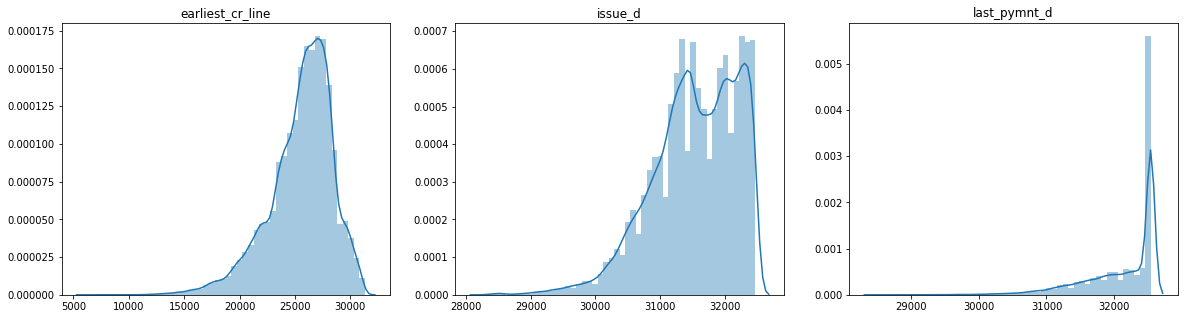

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plot_dist(df, 'earliest_cr_line', axs[0])
plot_dist(df, 'issue_d', axs[1])
plot_dist(df, 'last_pymnt_d', axs[2])

We have analyzed and preprocessed all categorical features. **Let's now analyze non-categorical features**.

## Non-categorical features

Let's summarize our datatypes after dealing with categorical features.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 1758049 to 2145511
Data columns (total 59 columns):
term                       80000 non-null float64
int_rate                   80000 non-null float64
installment                80000 non-null float64
annual_inc                 80000 non-null float64
issue_d                    80000 non-null int64
loan_status                80000 non-null float64
dti                        79944 non-null float64
earliest_cr_line           79998 non-null float64
recoveries                 80000 non-null float64
last_pymnt_d               79906 non-null float64
application_type           80000 non-null float64
home_ownership_ANY         80000 non-null float64
home_ownership_MORTGAGE    80000 non-null float64
home_ownership_NONE        80000 non-null float64
home_ownership_OTHER       80000 non-null float64
home_ownership_OWN         80000 non-null float64
home_ownership_RENT        80000 non-null float64
grade_A                    80000 no

As we see, **all features are now non-categorical**. Let's plot distributions of these non-categorical features which we haven't seen yet.

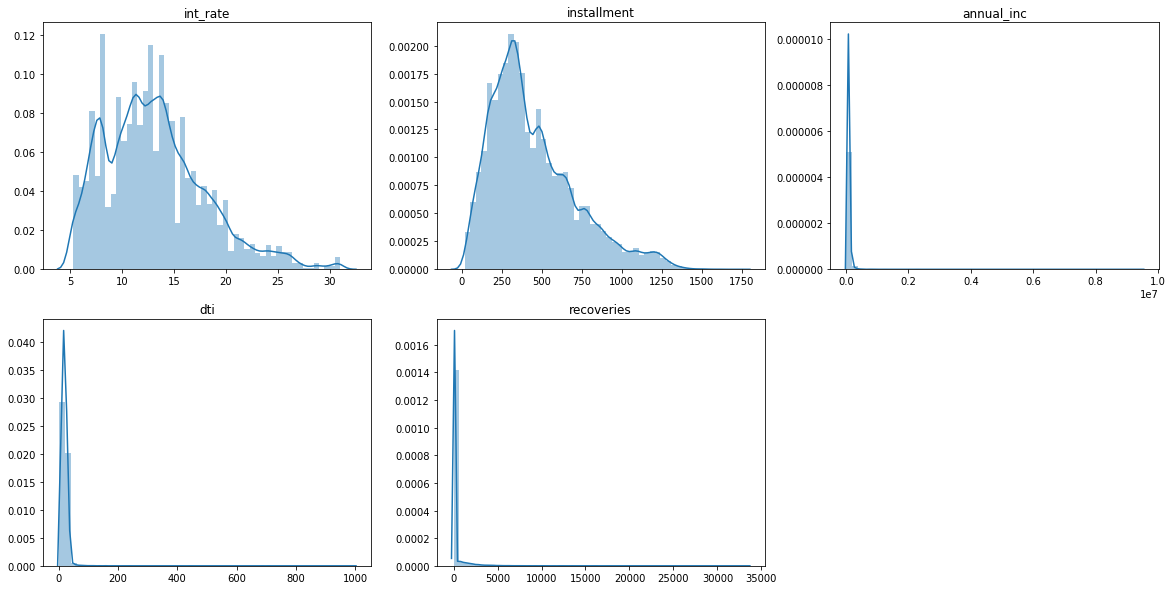

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plot_dist(df, 'int_rate', axs[0][0])
plot_dist(df, 'installment', axs[0][1])
plot_dist(df, 'annual_inc', axs[0][2])
plot_dist(df, 'dti', axs[1][0])
plot_dist(df, 'recoveries', axs[1][1])
fig.delaxes(axs[1][2])

Some values may be **outliers**. This issue will be concidered further, before training the models.

Now I will **split dataset into training and testing sets**.

## Train-test split

The test set will contain **20%** of the whole dataset (**16 000 rows**). The train set will contain the rest (**64 000 rows**).
* train size: **64 000**
* test size: **16 000**

Since we are dealing with strongly unbalanced data, I decided to use ***stratification*** parameter for splitting the dataset. It will result in the same *positive to negative labels ratio* in both training and testing sets. It would simulate sampling larger splits from larger datasets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['loan_status']),
    df.loan_status,
    test_size=0.2,
    stratify=df.loan_status,
    random_state=42
)

Now we need to **deal with missing values**.

## Missing values imputation

I will impute missing values into both training and testing sets but **using only training set estimates**. It is important because now (after applying train-test split) we are forced to use only training data.

Class ***IterativeImputer*** enables modeling each feature with missing values as a function of other features, and using that estimate for imputation. This solution brought better results than ***SimpleImputer*** which was able to impute only some simple statistics like mean or median.

In [29]:
imputer = IterativeImputer(random_state=42).fit(X_train)
X_train[:] = imputer.transform(X_train)
X_test[:] = imputer.transform(X_test)

## Feature selection

Let's now apply feature selection in order to **prevent overfitting**. I will train ***ExtraTreesClassifier*** on the training data and **select the most important features from this model**.

In [30]:
X_train.head()

,term,int_rate,installment,annual_inc,issue_d,dti,earliest_cr_line,recoveries,last_pymnt_d,application_type,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
227884,60.0,11.55,550.45,35000.0,32323.0,19.44,28763.0,0.0,32507.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1524647,36.0,10.42,259.72,60000.0,31989.0,5.74,26875.0,0.0,32538.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129142,36.0,16.14,528.40,32000.0,32385.0,21.34,24411.0,0.0,32507.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753058,36.0,11.99,318.82,50000.0,31442.0,27.17,26936.0,0.0,32538.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1305819,36.0,6.92,373.18,35000.0,31077.0,29.36,25445.0,0.0,32173.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
clf = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)
feature_selection = SelectFromModel(clf, prefit=True)
columns = df.columns[clf.feature_importances_.argsort()[::-1][:8]]
X_train = pd.DataFrame(feature_selection.transform(X_train), columns=columns, index=X_train.index)
X_test = pd.DataFrame(feature_selection.transform(X_test), columns=columns, index=X_test.index)

Let's see which features were selected as the most important.

In [32]:
X_train.head()

,earliest_cr_line,recoveries,loan_status,dti,issue_d,annual_inc,installment,int_rate
227884,11.55,550.45,35000.0,32323.0,19.44,28763.0,0.0,32507.0
1524647,10.42,259.72,60000.0,31989.0,5.74,26875.0,0.0,32538.0
129142,16.14,528.40,32000.0,32385.0,21.34,24411.0,0.0,32507.0
753058,11.99,318.82,50000.0,31442.0,27.17,26936.0,0.0,32538.0
1305819,6.92,373.18,35000.0,31077.0,29.36,25445.0,0.0,32173.0


All selected features are non-categorical from very beginning. Therefore, we can apply **scaling** on them.

## Feature scaling

In [33]:
scaler = StandardScaler().fit(X_train)
X_train[:] = scaler.transform(X_train)
X_test[:] = scaler.transform(X_test)

## Removing outliers from training data

I decided to **remove outliers from training** data before training the model. As I examined, it would improve **generalization** and prevent **overfitting**. It is really important since we are dealing with **unbalanced** data. Moreover, the dataset contains values in different ranges (and I detected some outliers examining the charts).

The ***IsolationForest*** isolates observations by **randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature**. This solution is successfull because it doesn't assume that the dataset is sampled from any specific distribution.

I also examined a different solution - ***EllipticEnvelope*** - which removes outliers in a Gaussian distributed dataset. However, our variables are not expecially normally distributed, therefore this algorithm was removing too many datapoints and the classification models became unable to learn the training data distribution.

I estimated parameter **contamination** (proportion of detected outliers in the dataset) empirically.

In [34]:
outliers = IsolationForest(contamination=5e-3, random_state=42).fit_predict(pd.concat([X_train, y_train], axis=1))
X_train = X_train[outliers == 1]
y_train = y_train[outliers == 1]

/home/adamrajfer/nethone/.venv/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


It was the last preprocessing step. Now we can start **training the classification models**.

# Models

Some basis functions for displaying metrics are implemented below.

In [35]:
def plot_metrics(clf, X, y):
    y_ = clf.predict(X)
    print('Accuracy:\t{}\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
        accuracy_score(y, y_), precision_score(y, y_), recall_score(y, y_), f1_score(y, y_)))

def plot_metrics_train_test(clf, X_train, X_test, y_train, y_test):
    print('Train set:\n')
    plot_metrics(clf, X_train, y_train)
    print('\n\nTest set:\n')
    plot_metrics(clf, X_test, y_test)

My baseline model is ***GaussianNB*** - Gaussian Naive Bayes.

## GaussianNB

In [36]:
nb = GaussianNB().fit(X_train, y_train)
plot_metrics_train_test(nb, X_train, X_test, y_train, y_test)

Train set:

Accuracy:	0.9525596733668342
Precision:	1.0
Recall:		0.6086280606296153
F1:		0.7567045179995168


Test set:

Accuracy:	0.9525625
Precision:	1.0
Recall:		0.6216350947158524
F1:		0.7666769136181986


The scores are satisfactory. High presicion is good - we are not classifying negative values as positive. However, we could achieve better recall - our model could classify more positive values as positive. This is not an easy task since we are facing disproportion in number of labels (only 12,5% positive labels). Accuracy, in this  case, means nothing to us.

This simple solution is really fast and computationaly inexpensive. However, the data needed to be properly prepared by removing outliers, scaling the data and dropping redundant features.

Unfortunetelly, Naive Bayes algorithm won't be able to classify correctly data varying much from training data distribution.

My next approach is ***LogisticRegression***.

## LogisticRegression

In [37]:
logit = LogisticRegression(penalty='none', solver='lbfgs',random_state=42).fit(X_train, y_train)
plot_metrics_train_test(logit, X_train, X_test, y_train, y_test)

Train set:

Accuracy:	0.9526695979899498
Precision:	1.0
Recall:		0.6095349138489442
F1:		0.7574050225370252


Test set:

Accuracy:	0.952625
Precision:	1.0
Recall:		0.6221335992023929
F1:		0.7670559311616473


Since we removed outliers, scaled the data and dropped redundant features, no regularization is needed. Imputing missing values was also some kind of regularization.

Our recall is slightly better (~0.001) than achieved on GaussianNB. Since training metrics are slightly worse than testing metrics, we know that the model isn't overfitting. However, *LogisticRegression* assumes linearity between features and labels, which may not always be observable.

Let's now try more powerful model - ***RandomForestClassifier***.

## RandomForestClassifier

In [38]:
rf = RandomForestClassifier(max_features=8, max_leaf_nodes=300,random_state=42).fit(X_train, y_train)
plot_metrics_train_test(rf, X_train, X_test, y_train, y_test)

Train set:

Accuracy:	0.9623586683417086
Precision:	0.9947936035701004
Recall:		0.6930949604871097
F1:		0.816980988012522


Test set:

Accuracy:	0.9524375
Precision:	0.9567131327953045
Recall:		0.650049850448654
F1:		0.7741169486494508


This is the best achieved score. The model is classifying some negative points as positive, however, it is classifying more positive points correctly than *GaussianNB* or *LogisticRegression*.

Since feature selection was applied before, we could increase parameter ***max_features*** (the number of features to consider when looking for the best split). It helps the model to search for more regions in the training data distribution. On the other hand, setting parameter ***max_leaf_nodes*** (maximum number of nodes on each level of the tree) to smaller value (300) reduced overfitting.

**To sum up, I would use RandomForestClassifier because it enables searching for many regions in the training data distribution and provide many regularization techniques. This model is more computationaly expensive than LogisticRegression and GaussianNB, however, for unbalanced data with more complex distributions, it brings better results.**

# Further steps

If I was given more time, I would approach this problem in this way:
* I would try another encoding techniques for categorical variables and revisit feature selection process in order to represent and store the data in more reasonable way (for example variables correlation analysis).
* I would train another models or ensembles of models and validate them using k-fold validation.
* I would plot ROC curves and precision-recall curves.
* I would try undersampling approach while training in order to deal with unbalanced binary classification problem.
* If given more data and computing power, I would remove some preprocessing steps (like removing outliers from training data) and instead of it apply some regularization techniques like L1, L2 or adding random noise to the training data.
* I would try more efficient hyperparameter tuning (like grid-search).
* I would train a neural network.